# HRD Feature Engineering  |  COSMIC SBS3 Signatures

**Objective**: Generate SBS3-based HRD labels from DepMap cell line data to support downstream analyses of PARP inhibitor sensitivity across relevant cancer models.

---
---
---

## 1. Setup 📦

---
---

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import ptitprince as pt
import seaborn as sns

# Computational Modules
# from SigProfilerExtractor import sigpro as sig

# Utils
from IPython.display import display, HTML, IFrame, Image
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 200)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})

## 2. Data Loading ⚙️

**Objective**: Load and organize DepMap cell line data and external HRD-related feature sets.

---
---

In [2]:
# Define project root and file path relative to user OS
BASE_DIR = Path.cwd()
CCL_PARPI_PATH              = BASE_DIR / 'utils' / 'ccl_parpi_df.pkl'
CELL_LINE_MODELS_PATH       = BASE_DIR / 'data' / 'Models.csv'
CELL_LINE_CNTXT_PATH        = BASE_DIR / 'data' / 'cellLines_contexts.csv'
EXTRACTION_OUTPUT_PATH      = BASE_DIR / 'data' / 'SBS3_extraction_output'
SIGNATURES_PATH             = BASE_DIR / 'data' / 'mmc3.csv'

In [3]:
# Load data into local dataframes (with disabled chunked dtype inference)
ccl_parpi_df                = pd.read_pickle(CCL_PARPI_PATH)
ccl_models_df               = pd.read_csv(CELL_LINE_MODELS_PATH, low_memory=False)
ccl_cntxt_df                = pd.read_csv(CELL_LINE_CNTXT_PATH, low_memory=False)
ccl_sgn_exp_df              = pd.read_csv(SIGNATURES_PATH, low_memory=False)

The notebook integrates DepMap cell line [metadata](https://depmap.org/portal/data_page/?tab=allData) with externally sourced mutational signature data to facilitate HRD-related analyses.

- **`ccl_models_df`**: Contains comprehensive metadata for all cancer cell line models from DepMap (release 25Q3), including cell line names, COSMIC IDs, and clinical/contextual annotations.
- **`ccl_cntxt_df`**: Contains preprocessed 96‑channel trinucleotide mutation counts for each cell line, formatted for direct SBS signature extraction. [Source](https://www.nature.com/articles/s41467-022-30582-3#data-availability)
- **`ccl_sgn_exp_df`**: Contains externally published mutational signature exposure data for the corresponding cell lines. [Source](https://www.cell.com/cell/fulltext/S0092-8674%2819%2930161-8?utm_source=chatgpt.com)

All datasets are loaded locally and prepared for exploration, merging, and SBS3 exposure calculations.

This project aims to systematically examine how multiple definitions of HRD relate to drug response across all PARP inhibitors available in the dataset. So each of the HRD feature engineering notebooks will derive homologous recombination deficiency (HRD) status using one of three complementary strategies: (1) BRCA1/2 double-hit alteration status, (2) computed genomic scar–based HRD scores, and (3) COSMIC mutational signatures. These engineered features will then be harmonized with PARP inhibitor AUC measurements to generate a modeling-ready dataset for downstream statistical analysis and predictive modeling of HRD-associated drug response. This notebook specifically focuses on the third strategy, extracting SBS3 values from external mutational signature data.

## 3. COSMIC Mutational Signatures Exposure [HRD Component 3] 🔬

**Objective**: Use COSMIC mutational signatures to extract SBS3 exposure and derive HRD status across the DepMap cancer cell line cohort.

---
---

The **Catalogue Of Somatic Mutations In Cancer (COSMIC)** is a curated repository of somatic mutations across thousands of cancer genomes. Beyond cataloging individual mutations, COSMIC defines **mutational signatures**, which are reproducible patterns of nucleotide changes that reflect underlying biological processes, such as DNA repair deficiencies or exposure to specific mutagens.

**Single Base Substitution (SBS) signatures** quantify the probability of a specific nucleotide change within a trinucleotide context. Specifically, **SBS3** is strongly associated with HRD. Elevated SBS3 contribution in a cell line indicates a mutational footprint consistent with HRD.

Mutational signatures capture the accumulated mutational patterns in a genome. For DepMap cell lines, external datasets provide SBS3 exposure values per cell line, harmonized using COSMIC IDs. These values serve as quantitative HRD features for downstream analyses.

[Source](https://cancer.sanger.ac.uk/signatures/sbs/)

### 3a. Inspect and validate the mutational signature exposure values.

---

In [4]:
# Check feature set and missing values
display(ccl_sgn_exp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sample Name                      1001 non-null   object 
 1   Cancer Type used in SigProfiler  1001 non-null   object 
 2   Accuracy                         1001 non-null   float64
 3   SBS1                             1001 non-null   int64  
 4   SBS2                             1001 non-null   int64  
 5   SBS3                             1001 non-null   int64  
 6   SBS4                             1001 non-null   int64  
 7   SBS5                             1001 non-null   int64  
 8   SBS6                             1001 non-null   int64  
 9   SBS7a                            1001 non-null   int64  
 10  SBS7b                            1001 non-null   int64  
 11  SBS7c                            1001 non-null   int64  
 12  SBS7d               

None

In [5]:
# Check for duplicates
ccl_sgn_exp_df.duplicated(subset=['Sample Name']).sum()

0

In [6]:
columns_of_interest = [
    'Sample Name',                      # cell line identifier (for merging)
    'Cancer Type used in SigProfiler',  # context
    'SBS3',                             # primary mutational signature of interest
    'SBSSNP',                           # total SBS mutation burden
    'Accuracy'
]

ccl_sgn_exp_df = ccl_sgn_exp_df[columns_of_interest].copy()

The mutational signature dataset contains 1001 cancer cell lines with 44 columns, including exposures for SBS1–SBS40 and the aggregate single-base substitution count (`SBSSNP`). Each row corresponds to a single cell line, identified by its sample name, along with the cancer type used during SBS extraction and an accuracy metric for the signature assignment.

This table serves as the primary source for SBS3 exposure values, which will be aligned with DepMap metadata in downstream analyses. All SBS columns are complete, with no missing values, ensuring reliable merging and feature engineering. The primary features were selected for merging with DepMap CCL data.

### 3b. Prepare DepMap cell line data for merge.

---

The full DepMap cell line metadata will be used as the reference set for HRD score integration to ensure comprehensive coverage across all available cancer models, rather than restricting to the curated set. This is to maintain flexibility for future analyses beyond the current project scope. 

A subsequent notebook will integrate the curated PARPi cohort with all the engineered HRD features later, at which point this SBS3 data will be aligned with the drug-response subset in a unified and methodologically consistent manner.

In [7]:
# Retain only metadata columns relevant for downstream analysis
columns_of_interest = [
    # Identifiers
    'ModelID',
    'CellLineName',
    
    # Lineage Annotation
    'OncotreeLineage',
    'OncotreePrimaryDisease',
    'OncotreeSubtype',
    
    # Patient Context
    'Age',
    'AgeCategory',
    'Sex',
    'PatientRace',
    
    # Bio Context
    'PrimaryOrMetastasis',
    'GrowthPattern',
]

# Subset dataframe
ccl_models_df = (
    ccl_models_df[columns_of_interest]
    .copy()
)

In [8]:
# Check for any duplicate ccl records
print(ccl_models_df.duplicated().sum())

# Check for missing DepMap IDs
print(ccl_models_df.ModelID.isna().sum())

0
0


In [9]:
ccl_models_df

,ModelID,CellLineName,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,GrowthPattern
0,ACH-000001,NIH:OVCAR-3,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,60.0,Adult,Female,caucasian,Metastatic,Adherent
1,ACH-000002,HL-60,Myeloid,Acute Myeloid Leukemia,AML with Myelodysplasia-Related Changes,36.0,Adult,Female,caucasian,Primary,Suspension
2,ACH-000003,CACO2,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,72.0,Adult,Male,caucasian,Primary,Adherent
3,ACH-000004,HEL,Myeloid,Acute Myeloid Leukemia,"AML, NOS",30.0,Adult,Male,caucasian,Primary,Suspension
4,ACH-000005,HEL 92.1.7,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,30.0,Adult,Male,caucasian,NaN,Mixed
...,...,...,...,...,...,...,...,...,...,...,...
2127,ACH-003473,CCLF_PEDS_0013_T,Soft Tissue,Rhabdomyosarcoma,Embryonal Rhabdomyosarcoma,1.0,Pediatric,Female,caucasian,Primary,Adherent
2128,ACH-003474,CCLF_HNSC_0001_T,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,77.0,Adult,Male,caucasian,Primary,Adherent
2129,ACH-003475,CCLF_HNSC_0003_T,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Metastatic,Adherent
2130,ACH-003476,CCLF_HNSC_0002_T,Esophagus/Stomach,Esophageal Squamous Cell Carcinoma,Esophageal Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Primary,Adherent


Initial integrity checks confirm that there are no duplicate records. `CellLineName` will be used as the primary key merging external data.

### 3c. Merge mutational signature data with DepMap cell lines.

---

In [10]:
# Cross check available IDs with DepMap version
overlap_count = ccl_sgn_exp_df['Sample Name'].isin(ccl_models_df['CellLineName']).sum()
print('Number of overlapping cell lines: ', overlap_count)

Number of overlapping cell lines:  850


In [11]:
# Merge on cell line name
ccl_sbs3_df = ccl_models_df.merge(
    ccl_sgn_exp_df,
    left_on='CellLineName',
    right_on='Sample Name',
    how='left'
)

# # Drop records for models not in signatures data
# ccl_sbs3_df = ccl_sbs3_df.dropna(subset=['Sample Name'])

# Drop the keys and other features unnecessary for analysis
ccl_sbs3_df = ccl_sbs3_df.drop(
    columns=['CellLineName', 'Sample Name', ],
).reset_index(drop=True)

ccl_sbs3_df

,ModelID,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,GrowthPattern,Cancer Type used in SigProfiler,SBS3,SBSSNP,Accuracy
0,ACH-000001,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,60.0,Adult,Female,caucasian,Metastatic,Adherent,NaN,NaN,NaN,NaN
1,ACH-000002,Myeloid,Acute Myeloid Leukemia,AML with Myelodysplasia-Related Changes,36.0,Adult,Female,caucasian,Primary,Suspension,LAML,0.0,0.0,0.96
2,ACH-000003,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,72.0,Adult,Male,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN
3,ACH-000004,Myeloid,Acute Myeloid Leukemia,"AML, NOS",30.0,Adult,Male,caucasian,Primary,Suspension,LAML,0.0,0.0,0.96
4,ACH-000005,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,30.0,Adult,Male,caucasian,NaN,Mixed,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,ACH-003473,Soft Tissue,Rhabdomyosarcoma,Embryonal Rhabdomyosarcoma,1.0,Pediatric,Female,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN
2128,ACH-003474,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,77.0,Adult,Male,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN
2129,ACH-003475,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Metastatic,Adherent,NaN,NaN,NaN,NaN
2130,ACH-003476,Esophagus/Stomach,Esophageal Squamous Cell Carcinoma,Esophageal Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN


The external dataset was merged using the cell line name as the key, preserving all the HRD-related features along with some contextual cell line info from DepMap. There were 850 total overlapping records, meaning that the SBS3 data was extracted for less than half of the original DepMap cancer cell lines.

### 3d. Perform cursory explorations to determine preprocessing and HRD labeling strategies.

---

In [12]:
# Examine summary statistics 
ccl_sbs3_df[['Accuracy', 'SBS3', 'SBSSNP']].describe()

,Accuracy,SBS3,SBSSNP
count,850.000000,850.000000,850.000000
mean,0.956459,8.324706,8.011765
std,0.030919,101.994967,83.427771
min,0.350000,0.000000,0.000000
25%,0.950000,0.000000,0.000000
50%,0.960000,0.000000,0.000000
75%,0.970000,0.000000,0.000000
max,1.000000,2662.000000,1402.000000


The SBS3 exposures are highly sparse, with most cell lines having a value of 0 (median = 0, 75th percentile = 0). Only a few outliers carry substantial SBS3 burdens (maximum = 2,662). Accuracy remains consistently high across the dataset (mean ≈ 0.956), indicating the SBS3 estimates are generally reliable. SBSSNP values follow a similar sparse pattern, with a few extreme values driving the mean above the median.

In [13]:
# Examine number of 0s in SBS3 data
print((ccl_sbs3_df['SBS3'] == 0).sum())

836


The SBS3 mutational signature is present in only a small fraction of the cell lines. Out of 850 records, 836 cell lines have zero SBS3 mutations, leaving just 14 cell lines with detectable SBS3 exposure. This indicates that SBS3 is extremely sparse in this dataset, which will influence downstream HRD labeling strategies and threshold selection.

In [14]:
ccl_sbs3_df[ccl_sbs3_df['SBS3'] > 0]['Accuracy']

246     0.98
274     0.90
350     0.96
521     0.92
569     0.96
603     0.96
635     0.94
692     0.97
695     0.97
763     0.95
851     0.97
861     0.98
974     0.97
1643    0.97
Name: Accuracy, dtype: float64

All 14 cell lines with non-zero SBS3 exposure exhibit high accuracy scores, ranging from 0.90 to 0.98. This suggests that the SBS3 signal in these samples is reliable and suitable for downstream analyses despite the overall sparsity of the signature in the dataset.

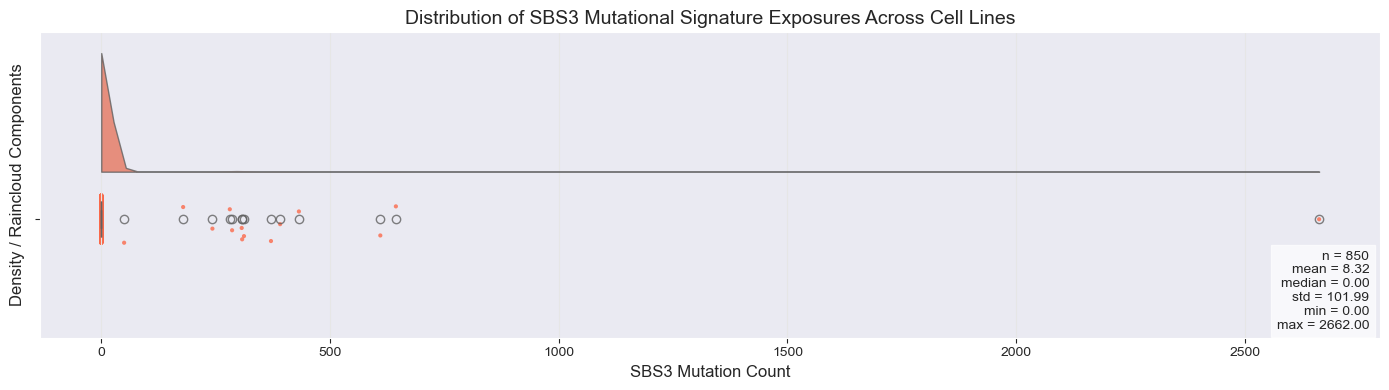

In [15]:
# Set up figure 
plt.figure(figsize=(14, 4))

# Plot raincloud for total SBS3 count
sbs_cnt_cloud = pt.RainCloud(
    data=ccl_sbs3_df,
    y='SBS3',
    bw=0.2,
    alpha=0.8,
    rain_alpha=0.8,
    width_viol=1,
    orient='h',
    palette='Reds',
    hue=0,
)

# Summary stats
summary_text = (f"n = {ccl_sbs3_df['SBS3'].count()}\n"
                f"mean = {ccl_sbs3_df['SBS3'].mean():.2f}\n"
                f"median = {ccl_sbs3_df['SBS3'].median():.2f}\n"
                f"std = {ccl_sbs3_df['SBS3'].std():.2f}\n"
                f"min = {ccl_sbs3_df['SBS3'].min():.2f}\n"
                f"max = {ccl_sbs3_df['SBS3'].max():.2f}")
plt.text(0.992, 0.02, summary_text, transform=plt.gca().transAxes,
         ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.title('Distribution of SBS3 Mutational Signature Exposures Across Cell Lines', fontsize=14)
plt.xlabel('SBS3 Mutation Count', fontsize=12)
plt.ylabel('Density / Raincloud Components', fontsize=12)
plt.tight_layout()
plt.show()

The non-zero SBS3 values show a clear separation from 0, suggesting that labeling cell lines with SBS3 > 0 as HRD-positive is a reliable strategy for downstream analyses.

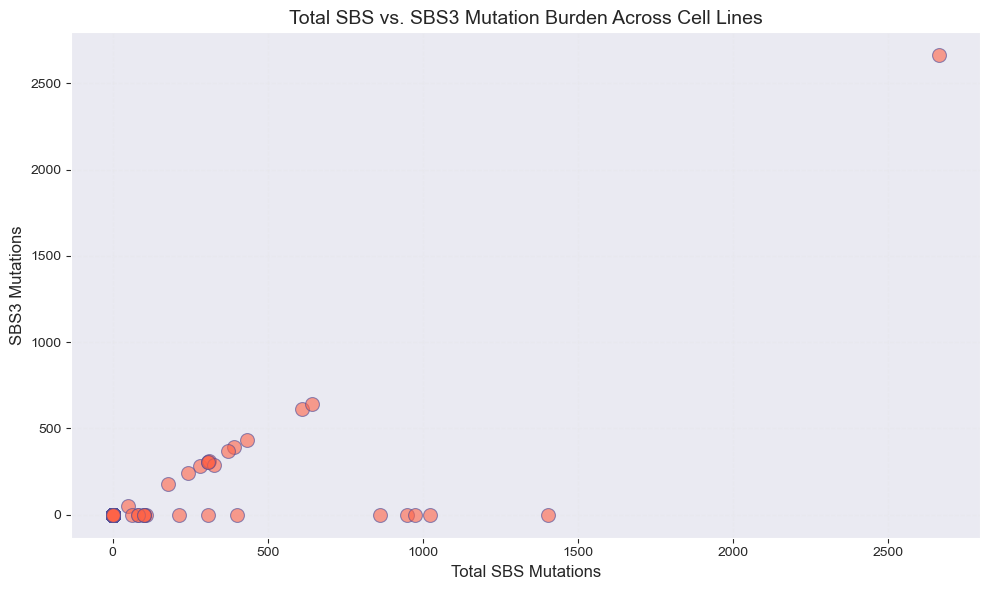

In [16]:
# Compute total SBS mutations
ccl_sbs3_df['total_sbs'] = ccl_sbs3_df.filter(like='SBS').sum(axis=1)

# Set up figure
plt.figure(figsize=(10, 6))

# Scatterplot
sns.scatterplot(
    x='total_sbs',
    y='SBS3',
    data=ccl_sbs3_df,
    s=100,                
    color='tomato',    
    edgecolor=(0.3,0.3,0.6,0.5), 
    alpha=0.6
)

# Formatting
plt.xlabel('Total SBS Mutations', fontsize=12)
plt.ylabel('SBS3 Mutations', fontsize=12)
plt.title('Total SBS vs. SBS3 Mutation Burden Across Cell Lines', fontsize=14)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

The scatterplot reveals a clear positive association between total SBS mutations and SBS3 counts. Most cell lines have low or zero SBS3, while the few with elevated SBS3 also show higher total mutation burdens, reinforcing that SBS3 contributes meaningfully to the overall mutational load and can be used as an HRD indicator.

### 3e. Construct SBS3-based HRD labels for the available cell lines.

---

In [17]:
# Create a binary flag for SBS3-based HRD
ccl_sbs3_df['hrd_sbs3'] = (ccl_sbs3_df['SBS3'] > 0).astype(int)

# Ensure 14 non-zero values are reflected in label
ccl_sbs3_df['hrd_sbs3'].value_counts()

hrd_sbs3
0    2118
1      14
Name: count, dtype: int64

## 4. Summary & Export 💾 

---
---

In [18]:
# Export merged data as reusable pickle file
ccl_sbs3_df.to_pickle(BASE_DIR / 'utils' / 'ccl_sbs3_df.pkl')

ccl_sbs3_df

,ModelID,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,GrowthPattern,Cancer Type used in SigProfiler,SBS3,SBSSNP,Accuracy,total_sbs,hrd_sbs3
0,ACH-000001,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,60.0,Adult,Female,caucasian,Metastatic,Adherent,NaN,NaN,NaN,NaN,0.0,0
1,ACH-000002,Myeloid,Acute Myeloid Leukemia,AML with Myelodysplasia-Related Changes,36.0,Adult,Female,caucasian,Primary,Suspension,LAML,0.0,0.0,0.96,0.0,0
2,ACH-000003,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,72.0,Adult,Male,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN,0.0,0
3,ACH-000004,Myeloid,Acute Myeloid Leukemia,"AML, NOS",30.0,Adult,Male,caucasian,Primary,Suspension,LAML,0.0,0.0,0.96,0.0,0
4,ACH-000005,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,30.0,Adult,Male,caucasian,NaN,Mixed,NaN,NaN,NaN,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,ACH-003473,Soft Tissue,Rhabdomyosarcoma,Embryonal Rhabdomyosarcoma,1.0,Pediatric,Female,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN,0.0,0
2128,ACH-003474,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,77.0,Adult,Male,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN,0.0,0
2129,ACH-003475,Head and Neck,Head and Neck Squamous Cell Carcinoma,Head and Neck Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Metastatic,Adherent,NaN,NaN,NaN,NaN,0.0,0
2130,ACH-003476,Esophagus/Stomach,Esophageal Squamous Cell Carcinoma,Esophageal Squamous Cell Carcinoma,76.0,Adult,Female,caucasian,Primary,Adherent,NaN,NaN,NaN,NaN,0.0,0


This notebook incorporates SBS3 mutation exposure values as part of HRD profiling for the available cell lines. These values are derived by decomposing each cell line’s 96-channel trinucleotide mutation counts using computational mutational signature extraction (e.g., via SigProfiler or similar non-negative matrix factorization approaches). 

The process quantifies the contribution of known COSMIC mutational signatures, including SBS3, to the overall mutation profile of each cell line. A binary flag (`hrd_sbs3`) was generated to label HRD-positive lines, providing a standardized feature for downstream analyses linking HRD status to PARP inhibitor response.

## [SUPPLEMENTARY] Exploratory Decomposition Using Mutational Signatures Dataset

---
---

In [19]:
# # Ensure no negative values
# ccl_cntxt_df.iloc[:, 2:98].describe()

# # Define SBS vs non-SBS columns for ease of use
# non_sbs_cols = [
#     'ModelID',
#     'OncotreeLineage',
#     'OncotreePrimaryDisease',
#     'OncotreeSubtype',
#     'Age',
#     'AgeCategory',
#     'Sex',
#     'PatientRace',
#     'PrimaryOrMetastasis',
#     'GrowthPattern',
#     'cancer_type',
#     'MH',
#     'MS',
#     'Insertion',
#     'Other'
# ]
# sbs_cols = [col for col in ccl_sbs3_df.columns if col not in non_sbs_cols]

# # Verify there are 96 channels
# print('Number of SBS channels detected:', len(sbs_cols))

The dataset contains 929 cell lines with complete trinucleotide mutation context counts across 96 channels (`ACA>A` through `TTT>G`). Additional features include `MH` (microhomology-mediated indels), `MS` (microsatellite-associated indels), `Insertion`, and `Other` mutation types.

All columns are fully populated, indicating no missing values. The `COSMIC_ID` provides a stable external identifier for each cell line, while `cancer_type` allows stratification by lineage. These 96-channel counts form the input for mutational signature extraction, including SBS3, which serves as the HRD-relevant output in this notebook.

Since the data only contains 929 records, this means that the coverage won't extend fully to the DepMap cell lines. However, the inspection confirms at least that the dataset is complete and suitable for downstream mutational signature analyses.

In [20]:
# # Compute total SBS mutation burden per cell line
# ccl_sbs3_df['total_sbs_mutations'] = ccl_sbs3_df[sbs_cols].sum(axis=1)

# # Set up figure 
# plt.figure(figsize=(14, 4))

# # Plot raincloud for total SBS mutation count
# sbs_cnt_cloud = pt.RainCloud(
#     data=ccl_sbs3_df,
#     y='total_sbs_mutations',
#     bw=0.2,
#     alpha=0.8,
#     rain_alpha=0.8,
#     width_viol=1,
#     orient='h',
#     palette='Reds',
#     hue=0,
# )

# # Summary stats
# summary_text = (f"n = {ccl_sbs3_df['total_sbs_mutations'].count()}\n"
#                 f"mean = {ccl_sbs3_df['total_sbs_mutations'].mean():.2f}\n"
#                 f"median = {ccl_sbs3_df['total_sbs_mutations'].median():.2f}\n"
#                 f"std = {ccl_sbs3_df['total_sbs_mutations'].std():.2f}\n"
#                 f"min = {ccl_sbs3_df['total_sbs_mutations'].min():.2f}\n"
#                 f"max = {ccl_sbs3_df['total_sbs_mutations'].max():.2f}")
# plt.text(0.992, 0.02, summary_text, transform=plt.gca().transAxes,
#          ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# # Compute and display candidate thresholds
# percentile_75_thresh = ccl_sbs3_df['total_sbs_mutations'].quantile(0.75)
# std_based_thresh    = ccl_sbs3_df['total_sbs_mutations'].mean() + 2 * ccl_sbs3_df['total_sbs_mutations'].std()
# plt.axvline(percentile_75_thresh, color='orange', linestyle='--', 
#             label=f'75th percentile\n({percentile_75_thresh:.2f})')
# plt.axvline(std_based_thresh, color='red', linestyle='--', 
#             label=f'Mean + 2*std\n({std_based_thresh:.2f})')
# handles, labels = plt.gca().get_legend_handles_labels()  # only thresholds legend
# plt.legend(handles[-2:], labels[-2:])

# plt.title('Distribution of Total SBS Mutation Burden Across Cell Lines')
# plt.xlabel('Total SBS Mutation Count (96-channel sum)')
# plt.ylabel('Number of Cell Lines')
# plt.tight_layout()
# plt.show()

This distribution reflects the mutation burden across the 906 cell lines with available SBS context data. All models included here have non-zero mutation counts, confirming proper alignment between the the external mutational signature dataset and the available DepMap cell lines within it. 

The median SBS mutation count is 128, with an interquartile range of 80–244 mutations, indicating that most models have sufficient mutation burden for stable signature decomposition. The distribution remains right-skewed, driven by a subset of hypermutated cell lines with mutation counts exceeding 10000. The minimum burden of 15 mutations suggests that some models may still fall near the lower limit for reliable signature fitting, which should be considered when defining thresholds for downstream SBS3-based HRD labeling.

Overall, this subset appears appropriate for mutational signature analysis, with adequate mutation depth in the majority of models and identifiable high-burden outliers that may warrant sensitivity analyses. 

**Run NMF-based deconvolution to generate SBS3 exposure values per cell line**:

In [21]:
# # Prepare input: rows = cell lines, cols = 96 trinucleotide contexts
# input_matrix = ccl_cntxt_df[sbs_cols].copy()

# # Execute 
# sig.sigProfilerExtractor(
#     'matrix',              
#     str(EXTRACTION_OUTPUT_PATH),  
#     input_matrix,               # mutation counts
#     reference_genome='GRCh37',  # genome reference
#     minimum_signatures=1,       # min signatures to try
#     maximum_signatures=10,      # max signatures to try
#     nmf_replicates=10,          # number of iterations for exacting each number signature
#     verbose=False, 
# )